# CIFAR-10 Image Classification Based on CNN
根据卷积神经网络（CNN）模型的发展历程，提出适用于CIFAR-10数据集的模型，采用数据增强与学习率衰减等手段，进行模型训练，并采用Tensorboard进行可视化。
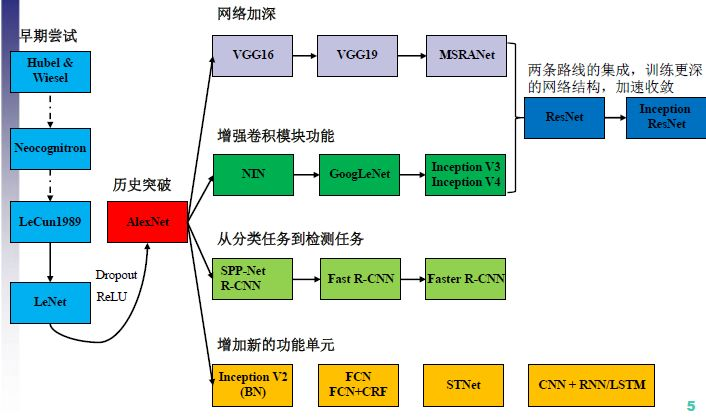

## Pretreat

In [1]:
# import packages
import torch
import torchvision

'1.7.1+cu101'

In [2]:
# Device configuration.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Transform configuration and data augmentation.
transform_train = torchvision.transforms.Compose([torchvision.transforms.Pad(2),
                                                 torchvision.transforms.RandomHorizontalFlip(),
                                                 torchvision.transforms.RandomCrop(32),
                                                 torchvision.transforms.ToTensor(),
                                                 torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
transform_test = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

In [5]:
# Hyper-parameters
num_classes = 10
batch_size = 100
learning_rate = 0.001
num_epochs = 80

In [6]:
# Load downloaded dataset.
train_dataset = torchvision.datasets.CIFAR10('../data/CIFAR10/', download=False, train=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10('../data/CIFAR10/', download=False, train=False, transform=transform_test)

In [7]:
# Data Loader.
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## Models
https://paperswithcode.com/sota/image-classification-on-cifar-10

### LeNet-5
由两个卷积层，两个池化层，两个全连接层组成。卷积核都是5×5，stride=1，池化层使用maxpooling

In [8]:
class LeNet5(torch.nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.layer1 = torch.nn.Sequential(torch.nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=0),
                                          torch.nn.BatchNorm2d(16),
                                          torch.nn.ReLU(),
                                          torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = torch.nn.Sequential(torch.nn.Conv2d(16, 40, kernel_size=5, stride=1, padding=0),
                                          torch.nn.BatchNorm2d(40),
                                          torch.nn.ReLU(),
                                          torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = torch.nn.Sequential(torch.nn.Linear(5* 5 * 40, 400),
                                       torch.nn.ReLU())
        self.fc2 = torch.nn.Sequential(torch.nn.Linear(400, 200),
                                       torch.nn.ReLU())
        self.fc3 = torch.nn.Linear(200, num_classes)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

### AlexNet

In [9]:
class AlexNet(torch.nn.Module):
    def __init__(self, num_classes, init_weights=False):
        super(AlexNet, self).__init__()
        self.layer1 = torch.nn.Sequential(torch.nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=2),
                                          torch.nn.BatchNorm2d(64),
                                          torch.nn.ReLU(inplace=True),
                                          torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=0))
        
        self.layer2 = torch.nn.Sequential(torch.nn.Conv2d(64, 192, kernel_size=4, stride=1, padding=1),
                                          torch.nn.BatchNorm2d(192),
                                          torch.nn.ReLU(inplace=True),
                                          torch.nn.MaxPool2d(kernel_size=2, stride=1, padding=0))
        
        self.layer3 = torch.nn.Sequential(torch.nn.Conv2d(192, 384, kernel_size=3, padding=1),
                                          torch.nn.BatchNorm2d(384),
                                          torch.nn.ReLU(inplace=True))
        
        self.layer4 = torch.nn.Sequential(torch.nn.Conv2d(384, 256, kernel_size=3, padding=1),
                                          torch.nn.BatchNorm2d(256),
                                          torch.nn.ReLU(inplace=True))
        
        self.layer5 = torch.nn.Sequential(torch.nn.Conv2d(256, 256, kernel_size=3, padding=1),
                                          torch.nn.BatchNorm2d(256),
                                          torch.nn.ReLU(inplace=True),
                                          torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.avgpool = torch.nn.Sequential(torch.nn.AdaptiveAvgPool2d(output_size=(3, 3)))
        
        self.fc1 = torch.nn.Sequential(torch.nn.Dropout(p=0.5, inplace=False),
                                       torch.nn.Linear(256 * 3 * 3, 1024),
                                       torch.nn.ReLU(inplace=True))
        
        self.fc2 = torch.nn.Sequential(torch.nn.Dropout(p=0.5, inplace=False),
                                       torch.nn.Linear(1024, 1024),
                                       torch.nn.ReLU(inplace=True))
        
        self.fc3 = torch.nn.Sequential(torch.nn.Dropout(p=0.5, inplace=False),
                                       torch.nn.Linear(1024, num_classes))
        if init_weights:
            self._initialize_weights()
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.avgpool(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.Linear):
                torch.nn.init.normal_(m.weight, 0, 0.01)
                torch.nn.init.constant_(m.bias, 0)

### VGGNet
VGG-16、VGG-19

In [10]:
# Define VGG-16 and VGG-19.
cfg = {
    'VGG-16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'], 
    'VGG-19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512,'M']
}

In [11]:
# VGG-16 and VGG-19
class VGGNet(torch.nn.Module):
    def __init__(self, VGG_type, num_classes):
        super(VGGNet, self).__init__()
        self.features = self._make_layers(cfg[VGG_type])
        self.classifier = torch.nn.Linear(512, num_classes)
        
    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out
    
    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M': # MaxPool2d
                layers += [torch.nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [torch.nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           torch.nn.BatchNorm2d(x),
                           torch.nn.ReLU(inplace=True)]
                in_channels = x
        layers += [torch.nn.AvgPool2d(kernel_size=1, stride=1)]
        return torch.nn.Sequential(*layers) # The number of parameters is more than one.

### GoogLeNet

In [12]:
# Define BasicConv2d
class BasicConv2d(torch.nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = torch.nn.Conv2d(in_channels, out_channels, **kwargs)
        self.batchnorm = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        return x

In [13]:
# Define InceptionAux.
class InceptionAux(torch.nn.Module):
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()
        self.avgpool = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv = BasicConv2d(in_channels, 128, kernel_size=1)
        self.fc1 = torch.nn.Sequential(torch.nn.Linear(2 * 2 * 128, 256))
        self.fc2 = torch.nn.Linear(256, num_classes)
        
    def forward(self, x):
        out = self.avgpool(x)
        out = self.conv(out)
        out = out.view(out.size(0), -1)
        out = torch.nn.functional.dropout(out, 0.5, training=self.training)
        out = torch.nn.functional.relu(self.fc1(out), inplace=True)
        out = torch.nn.functional.dropout(out, 0.5, training=self.training)
        out = self.fc2(out)
        return out

In [14]:
# Define Inception.
class Inception(torch.nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(Inception, self).__init__()
        self.branch1 = BasicConv2d(in_channels, ch1x1, kernel_size=1)
        self.branch2 = torch.nn.Sequential(BasicConv2d(in_channels, ch3x3red, kernel_size=1),
                                            BasicConv2d(ch3x3red, ch3x3, kernel_size=3, padding=1))
        self.branch3 = torch.nn.Sequential(BasicConv2d(in_channels, ch5x5red, kernel_size=1),
                                           BasicConv2d(ch5x5red, ch5x5, kernel_size=5, padding=2))
        self.branch4 = torch.nn.Sequential(torch.nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
                                           BasicConv2d(in_channels, pool_proj, kernel_size=1))
        
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        
        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, 1)

In [15]:
# Define GooLeNet.
class GoogLeNet(torch.nn.Module):
    def __init__(self, num_classes, aux_logits=True, init_weights=False):
        super(GoogLeNet, self).__init__()
        self.aux_logits = aux_logits
        self.conv1 = BasicConv2d(3, 64, kernel_size=4, stride=2, padding=3)
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)
        self.conv2 = BasicConv2d(64, 64, kernel_size=1)
        self.conv3 = BasicConv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2, stride=1, ceil_mode=True)
        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)
        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)
        self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)
        
        if self.aux_logits:
            self.aux1 = InceptionAux(512, num_classes)
            self.aux2 = InceptionAux(528, num_classes)
            
        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = torch.nn.Dropout(0.4)
        self.fc = torch.nn.Linear(1024, num_classes)
        if init_weights:
            self._initialize_weights()
            
    def forward(self, x):
        # N x 3 x 32 x 32
        x = self.conv1(x)
        # N x 64 x 18 x 18
        x = self.maxpool1(x)
        # N x 64 x 9 x 9
        x = self.conv2(x)
        # N x 64 x 9 x 9
        x = self.conv3(x)
        # N x 192 x 9 x 9
        x = self.maxpool2(x)
 
        # N x 192 x 8 x 8
        x = self.inception3a(x)
        # N x 256 x 8 x 8
        x = self.inception3b(x)
        # N x 480 x 8 x 8
        x = self.maxpool3(x)
        # N x 480 x 4 x 4
        x = self.inception4a(x)
        # N x 512 x 4 x 4
        
        if self.training and self.aux_logits: # eval model lose this layer
            aux1 = self.aux1(x)
 
        x = self.inception4b(x)
        # N x 512 x 4 x 4
        x = self.inception4c(x)
        # N x 512 x 4 x 4
        x = self.inception4d(x)
        # N x 528 x 4 x 4
        if self.training and self.aux_logits: # eval model lose this layer
            aux2 = self.aux2(x)
 
        x = self.inception4e(x)
        # N x 832 x 4 x 4
        x = self.maxpool4(x)
        # N x 832 x 2 x 2
        x = self.inception5a(x)
        # N x 832 x 2 x 2
        x = self.inception5b(x)
        # N x 1024 x 2 x 2
 
        x = self.avgpool(x)
        # N x 1024 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 1024
        x = self.dropout(x)
        x = self.fc(x)
        # N x 10 (num_classes)
        if self.training and self.aux_logits: # eval model lose this layer
            return x, aux2, aux1
        return x
 
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.Linear):
                torch.nn.init.normal_(m.weight, 0, 0.01)
                torch.nn.init.constant_(m.bias, 0)
                

### ResNet
ResNet-18、ResNet-34、ResNet-50

In [16]:
# Define 3x3 convolution.
def conv3x3(in_channels, out_channels, stride=1):
    return torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

# Define Residual block
class ResidualBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = torch.nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample :
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [17]:
# Define ResNet-18
class ResNet(torch.nn.Module):
    def __init__(self, block, layers, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = torch.nn.BatchNorm2d(16)
        self.relu = torch.nn.ReLU(inplace=True)
        self.layer1 = self._make_layers(block, 16, layers[0])
        self.layer2 = self._make_layers(block, 32, layers[1], 2)
        self.layer3 = self._make_layers(block, 64, layers[2], 2)
        self.layer4 = self._make_layers(block, 128, layers[3], 2)
        self.avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.fc = torch.nn.Linear(128, num_classes)
        
    def _make_layers(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = torch.nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                torch.nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return torch.nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

## Tensorboard

In [18]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('../tensorboadrd/GoogLeNet')

In [19]:
# get training images.
data_iter = iter(train_loader)
images, labels = data_iter.next()

In [20]:
# create grid of images
img_grid = torchvision.utils.make_grid(images)

In [21]:
# write to tensorboard
writer.add_image('CIFAR10_images', img_grid)

## Training

In [22]:
# Make model
model = GoogLeNet(num_classes, False, True).to(device)

In [23]:
writer.add_graph(model, images.to(device))

In [24]:
# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [25]:
# For updating learning rate.
def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
# Train the model.
import gc
total_step = len(train_loader)
curr_lr = learning_rate
running_loss = 0.0
for epoch in range(num_epochs):
    gc.collect()
    torch.cuda.empty_cache()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass.
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 100,
                            epoch * len(train_loader) + i)
            running_loss = 0.0
    # Decay learning rate.
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

Epoch [1/80], Step [100/500], Loss: 1.7892
Epoch [1/80], Step [200/500], Loss: 1.4813
Epoch [1/80], Step [300/500], Loss: 1.4148
Epoch [1/80], Step [400/500], Loss: 1.3334
Epoch [1/80], Step [500/500], Loss: 1.0703


## Testing

In [ ]:
# Test the model.
class_probs = []
class_preds = []
model.eval()
with torch.no_grad():
    total = 0
    correct = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        class_probs_batch = [torch.nn.functional.softmax(el, dim=0) for el in outputs]
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        class_probs.append(class_probs_batch)
        class_preds.append(predicted)
        
    print ('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

In [ ]:
test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_preds = torch.cat(class_preds)

In [ ]:
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [ ]:
def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]
    writer.add_pr_curve(classes[class_index],
                        tensorboard_preds,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

In [ ]:
# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_preds)